<a href="https://colab.research.google.com/github/Ahmed-Wassel-Angar/sales-predictions/blob/main/Sales_Prediction_Final_(not_finished).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# Mounting google.colab.drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# modeling packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_squared_log_error,r2_score
# set default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

In [96]:
# Loading Dataset

filepath="/content/drive/MyDrive/Coding Dojo/Data Sets/sales_predictions_2023.csv"
df=pd.read_csv(filepath)

In [97]:
# Creating the data_dictionary
data_dictionary=pd.Series(index=df.dtypes.index,data=np.array([np.dtype('O'),np.dtype('float64'),np.dtype('O'),np.dtype('float64'),\
                                                              np.dtype('O'),np.dtype('float64'),np.dtype('O'),np.dtype('int64'),\
                                                              np.dtype('O'),np.dtype('O'),np.dtype('O'),np.dtype('float64')]))

In [98]:
# @title Instantiate customized functions for EDA
# Instantiate functions

def explore_structure(df,dict,miss_val=True):
  header="-"*120
  print(header,sep="\n")

  # Addressing features' data types
  print("Addressing features' data types:")
  for col in data_dictionary.index:
    try:
      df=df.astype({col:data_dictionary[col]})
      print(f"  - {col}: dtype ({data_dictionary[col]}). SUCCESS! " )
    except:
      print(f"  - WARNING!! : {col} :DID NOT CHANGE TYPE !!" )
  print(header,sep="\n")

  # Deteting duplicated rows
  num_duplicated_rows=df.duplicated().sum()
  print(f"- Number of duplicated rows: {num_duplicated_rows} rows | percentage = {(num_duplicated_rows/len(df) *100).round(2)} %",sep='\n')
  if num_duplicated_rows>0:
    df=df.drop_duplicates()
    print(f"- {num_duplicated_rows} duplicated rows were deleted !!")
  print(header,sep="\n")

  # Deleting obsolete rows
  lenght=len(df)
  df=df.dropna(how="all")
  print(f"- {lenght-len(df)} obsolete rows were deleted !!")

  # Printing df's new shape and infos
  print(header,sep="\n")
  print(f"- Updated Shape: {df.shape}")
  print(header,sep="\n")
  print("- Updated Infos:")
  df.info()
  print(header,sep="\n")

  # Displaying missing values graph if miss_val=True (True is default value)
  if miss_val:
    print("MISSING VALUES:")
    print(msno.matrix(df))
  print(header,sep="\n")
def explore_numeric(df,num_cols=None,threshold=0):
  header="-"*120

  if num_cols is None:
    num_cols = df.select_dtypes('number').columns

  print(f"Numeric columns: {len(num_cols)} features",sep="\n")
  display(df[num_cols].describe())
  print(header,sep="\n")
  for col in num_cols:
    print(f"  {col}: numeric column",sep="\n")
    print(f"- Number of Null values (drop rows if % less than 2%) = {df[col].isna().sum()} nulls ({(df[col].isna().sum()/len(df[col]) *100).round(2)} %)")
    if df[col].isna().sum()/len(df[col])*100 > threshold:
      df.dropna(subset=[col])
      print(f"{df[col].isna().sum()} rows droped from the dataset")
    print(f"- Cardinality (high if > 10)= {df[col].nunique()} unique values ({round(df[col].nunique()/len(df[col]) *100,2)} %)")
    val_counts=df[col].value_counts(dropna=False)
    # Define the most common value
    most_common_val = val_counts.index[0]
    # Define the frequency of the most common value
    freq = val_counts.values[0]
    # Calculate the percentage of the most common value
    perc_most_common = freq / len(df) * 100
    # Print the results
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    # print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common > 98:
      print(f"\n- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant.")
    print(header,sep="\n")

def explore_categorical(df,cat_cols=None,threshold=0):

  header="-"*120

  if cat_cols is None:
    cat_cols = df.select_dtypes('object').columns

  print(f"Categorical columns: {len(cat_cols)} features",sep="\n")
  display(df[cat_cols].head(1))
  print(header,sep="\n")
  for col in cat_cols:
    print(f"  {col}: Categorical column",sep="\n")
    print(f"- Number of Null values (drop rows if % less than 2%) = {df[col].isna().sum()} nulls ({(df[col].isna().sum()/len(df[col]) *100).round(2)} %)")
    if df[col].isna().sum()/len(df[col])*100 < threshold:
      df.dropna(subset=[col])
      print(f"{df[col].isna().sum()} rows droped from the dataset")
    print(f"- Cardinality (high if > 10)= {df[col].nunique()} unique values ({round(df[col].nunique()/len(df[col]) *100,2)} %)")

    print("- Value Counts :",sep='\n')
    val_counts=df[col].value_counts(dropna=False)
    for i in range(0,len(val_counts)):
      print(f"  {val_counts.index[i]}: {val_counts.values[i]} ({round(100*val_counts.values[i]/len(df[col]),2)} %) ")
    # Define the most common value
    most_common_val = val_counts.index[0]
    # Define the frequency of the most common value
    freq = val_counts.values[0]
    # Calculate the percentage of the most common value
    perc_most_common = freq / len(df) * 100
    # Print the results
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    # print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common >= 98:
      print(f"\n- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant.")

    print(header,sep="\n")
def plot_categorical(df, x, y,figsize=(12,4), fillna = True, placeholder = 'MISSING', order = None):

  plt.style.use('seaborn')
  sns.set(font_scale=1)

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])

  # Create the figure and subplots

  fig, axes = plt.subplots(ncols=3,figsize=figsize)

  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  """

  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=axes[0], order=order)
  # Rotate Tick Labels for long names
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  axes[0].set_title(f"Column: {x}")

  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  """
  if x!=y:
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=axes[1], order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=axes[1],
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
    # Rotate xlabels
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    # Add a title
    axes[1].set_title(f"{x} vs. {y}")
    """Plots a boxplot for each category of the feature.
    """
    # Boxplot
    sns.boxplot(data=temp_df,x=x,y=y,ax=axes[2],order=order,linewidth=0.5)
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    axes[2].set_title(f"{x} vs. {y}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  return fig, axes

In [99]:
explore_structure(df,data_dictionary,miss_val=False)

------------------------------------------------------------------------------------------------------------------------
Addressing features' data types:
  - Item_Identifier: dtype (object). SUCCESS! 
  - Item_Weight: dtype (float64). SUCCESS! 
  - Item_Fat_Content: dtype (object). SUCCESS! 
  - Item_Visibility: dtype (float64). SUCCESS! 
  - Item_Type: dtype (object). SUCCESS! 
  - Item_MRP: dtype (float64). SUCCESS! 
  - Outlet_Identifier: dtype (object). SUCCESS! 
  - Outlet_Establishment_Year: dtype (int64). SUCCESS! 
  - Outlet_Size: dtype (object). SUCCESS! 
  - Outlet_Location_Type: dtype (object). SUCCESS! 
  - Outlet_Type: dtype (object). SUCCESS! 
  - Item_Outlet_Sales: dtype (float64). SUCCESS! 
------------------------------------------------------------------------------------------------------------------------
- Number of duplicated rows: 0 rows | percentage = 0.0 %
----------------------------------------------------------------------------------------------------------

- We have 8523 observations and 12 features in our Dataset.
- All features'types are in accordance with the data dictionary types.
- No duplicated rows were found.
- No Obsolete rows were found (a row is obsolete when all reltive features'values are missing).
- Columns `Item_Weight` and `Item_Size` have missing values.

Next, we will partition our features to numerical features and categorical features to ease our EDA.

In [100]:
num_cols=df.select_dtypes('number').columns
cat_cols=df.select_dtypes('object').columns
print(num_cols)
print(cat_cols)


Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')
Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


In [101]:
# Let's summarize the data to see the ditribution of the numeric features
print(df.describe())

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


- The only iconsistencey spotted is null values within feature `Item_Visibility`:
  - In fact, Items with 0 visibility and 0 sales should be investigeted with stakeholders; if they are obsolete *i.e* are no longer proposed to customers, **then they should be droped.**
  - Others are being sold with visibilities equal to 0. These should be treated as missing values of the `Item_Visibility` feature within our model, **thus replaced with NaNs.** Obviously, they will be iputed later on.

In [102]:
## Cheking obsolete rows that have 0 visibility and 0 sales
# Creating a filter for 0 visibility items
no_vis_items = df["Item_Visibility"]==0
# Creating a filter for item sales
no_sales_items = df["Item_Outlet_Sales"]==0
print(f"Number of obsolete items = {len(df[no_vis_items & no_sales_items])}")

Number of obsolete items = 0


There no obsolete items. Next, we will replace all null `Item_Visibility` by `np.nan`

In [103]:
df["Item_Visibility"]=df["Item_Visibility"].replace(0,np.nan)
print(f"{df['Item_Visibility'].isna().sum()} '0' values were replaced by NaN values")

526 '0' values were replaced by NaN values


Next, we will run our customized function to explore the numerical features.

In [104]:
explore_numeric(df,num_cols=num_cols,threshold=2)

Numeric columns: 5 features


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,7997.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.070482,140.992782,1997.831867,2181.288914
std,4.643456,0.050308,62.275067,8.371760,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.773750,0.031403,93.826500,1987.000000,834.247400
50%,12.600000,0.057792,143.012800,1999.000000,1794.331000
75%,16.850000,0.098109,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


------------------------------------------------------------------------------------------------------------------------
  Item_Weight: numeric column
- Number of Null values (drop rows if % less than 2%) = 1463 nulls (17.17 %)
1463 rows droped from the dataset
- Cardinality (high if > 10)= 415 unique values (4.87 %)
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.
------------------------------------------------------------------------------------------------------------------------
  Item_Visibility: numeric column
- Number of Null values (drop rows if % less than 2%) = 526 nulls (6.17 %)
526 rows droped from the dataset
- Cardinality (high if > 10)= 7879 unique values (92.44 %)
- Most common value: 'nan' occurs 526 times (6.17%)
- Not constant or quasi-constant.
------------------------------------------------------------------------------------------------------------------------
  Item_MRP: numeric column
- Number of Null values (drop rows if

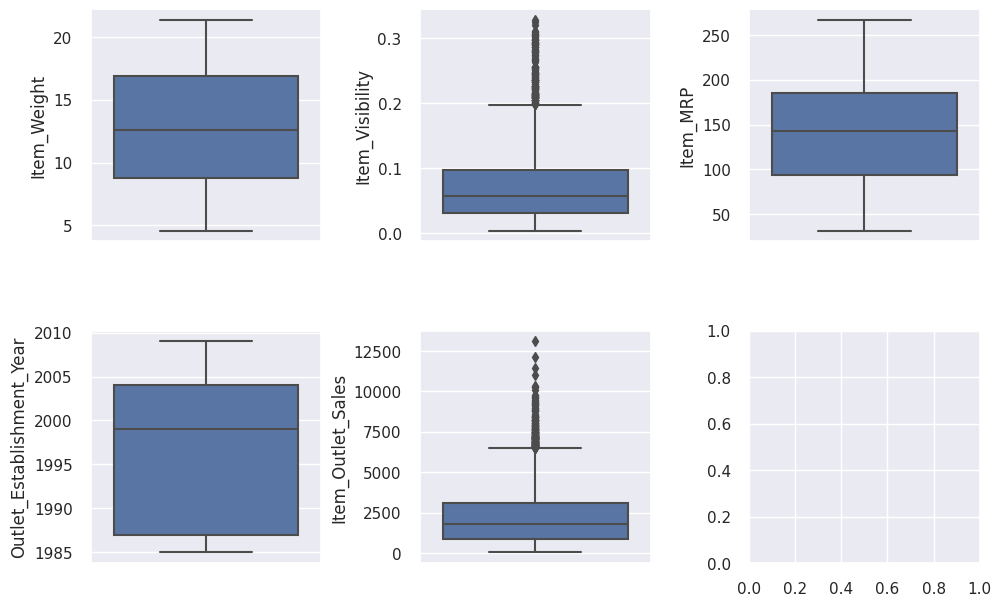

In [105]:
# let's visualize the boxplots of the numeric columns
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
index=0
axes=axes.flatten()
for col in num_cols:
  sns.boxplot(data=df,y=col,ax=axes[index])
  index +=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns `Item_Visibility` and `Item_Outlet_Sales` have some outliers. Let's calculate the percentage of the outliers.

In [106]:
for col in num_cols:
  v= df[col]
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  out_v = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  out_perc = round((out_v.shape[0] * 100 / df.shape[0]),2)
  print(f"Column {col} outliers = {out_perc}%")

Column Item_Weight outliers = 0.0%
Column Item_Visibility outliers = 1.64%
Column Item_MRP outliers = 0.0%
Column Outlet_Establishment_Year outliers = 0.0%
Column Item_Outlet_Sales outliers = 2.18%


=> these percentage are not significant so we will leave them as they are.

Checking the distribution of numeric features:

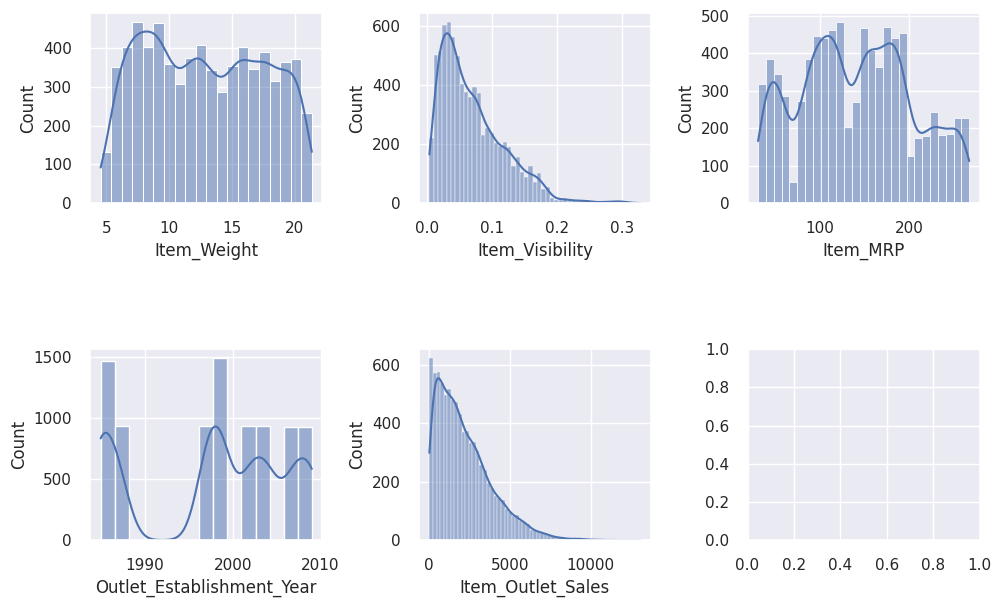

In [107]:
# let's visualize the hists. of the numeric columns
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
index=0
axes=axes.flatten()
for col in num_cols:
  sns.histplot(df[col],ax=axes[index],kde=True)
  index +=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

- `Item_Weight` and `Outlet_Establishment_Year` have almost no variantion in their distribution.
- `Item_Outlet_Sales` and `Item_Visibility` seem to have a Gamma ditribution.
- `item_MRP`seem to have multimodel ditribution. Also, the first 3 Sub-model distributions might be normal ones and the forth a uniformal one.

=> We will try to plot these against a our target which will be `Item_Outlet_Sales`

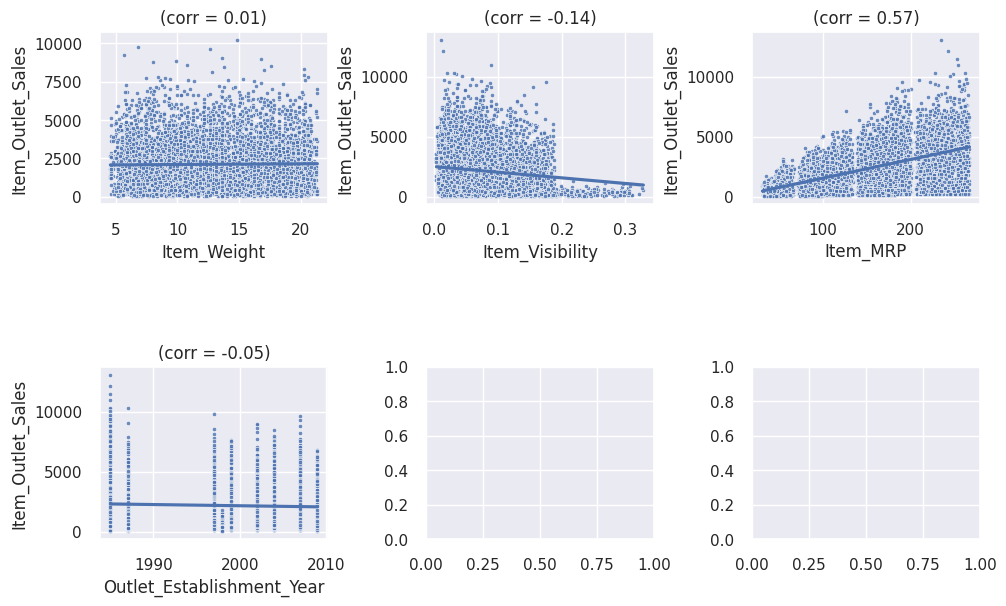

In [108]:
target="Item_Outlet_Sales"

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
index=0
scatter_kws={'ec':'white','lw':0.5,'alpha':0.8,'s':10}
axes=axes.flatten()
for col in num_cols.drop(target):
  corr=df[[col,target]].corr().round(2)
  r=corr.loc[col,target]
  sns.regplot(data=df,y=df[target],x=df[col],ax=axes[index],scatter_kws=scatter_kws)
  axes[index].set_title(f"(corr = {r})")
  index +=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

- The `Item_Weight` feature is equally distributed and has a correlation of almost 0 (`corr = 0.01`) with our target `Item_Outlet_Sales`. Plus, from a business point of view, it is unlikely that weights of items will affect our target (except for very heavy items which does not exist). Also, this feature have no outliers and present 17.7% of missing values that will be replaced with the mean value. So, statistacally speaking, nothing will change.
  **=> Therefor, we will drop it**
- The `Item_MRP` has an interesting distribution, that is oscilating around intervals of MRPs. this behaviour is most clear in the `regplot` of `Item_MRP` *vs* our target `Item_Outlet_Sales`. We distinguish 4 clearly separated bins of Items depending on different MRPs. The sales per Item per Outlet also tend to increase with the increase of the MRP.
- On one hand, the `Outlet_Establishment_Year` feature seems to have no influence on the target which is almost constant across all years (except of two) and a correlation of almost 0 (`corr = -0.05`). Plus, from a business point of view, the stackeholders can not affect or change the Outlet Establishment Year. On the other hand, the seniority of an outlet may indicate the degree of customers' loyality to the outlet and therefor impact the sales. So, we will not drop this feature but convert it to a categorical one indicating the outlet's seniority (`Outlet_Establishment_Year` has only 9 unique values and we will try to regroup them).

In [109]:
# Dropping "Item_Weight" feature
df=df.drop(columns=["Item_Weight"])

In [110]:
# getting unique values sorted by index along with freq
df.Outlet_Establishment_Year.value_counts(dropna=False).sort_index()

1985    1463
1987     932
1997     930
1998     555
1999     930
2002     929
2004     930
2007     926
2009     928
Name: Outlet_Establishment_Year, dtype: int64

=> We will create 3 categories : 1980s, 1990s,2000's

In [111]:
def fun(x):
  s=''
  if x<1990:
    s="1980s"
  elif x<2000:
    s="1990s"
  else:
    s="2000s"
  return s

df["Outlet_Seniority"]=df["Outlet_Establishment_Year"].apply( lambda x: fun(x))
df.Outlet_Seniority.value_counts(dropna=False)

2000s    3713
1990s    2415
1980s    2395
Name: Outlet_Seniority, dtype: int64

In [112]:
# Update columns nature
num_cols=df.select_dtypes('number')
cat_cols=df.select_dtypes('object')

Next, let's jump to exploring the categorical features.

In [113]:
# Let's summarize the data to see the ditribution of the categorical features
# "Item_Identifier" column have a very high cardinality (1559), we will drop it to adjust the display

explore_categorical(df)


Categorical columns: 8 features


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Seniority
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,1990s


------------------------------------------------------------------------------------------------------------------------
  Item_Identifier: Categorical column
- Number of Null values (drop rows if % less than 2%) = 0 nulls (0.0 %)
- Cardinality (high if > 10)= 1559 unique values (18.29 %)
- Value Counts :
  FDW13: 10 (0.12 %) 
  FDG33: 10 (0.12 %) 
  NCY18: 9 (0.11 %) 
  FDD38: 9 (0.11 %) 
  DRE49: 9 (0.11 %) 
  FDV60: 9 (0.11 %) 
  NCQ06: 9 (0.11 %) 
  FDF52: 9 (0.11 %) 
  FDX04: 9 (0.11 %) 
  NCJ30: 9 (0.11 %) 
  FDV38: 9 (0.11 %) 
  NCF42: 9 (0.11 %) 
  FDT07: 9 (0.11 %) 
  FDW26: 9 (0.11 %) 
  NCL31: 9 (0.11 %) 
  FDU12: 9 (0.11 %) 
  FDG09: 9 (0.11 %) 
  FDQ40: 9 (0.11 %) 
  FDX20: 9 (0.11 %) 
  NCI54: 9 (0.11 %) 
  FDX31: 9 (0.11 %) 
  FDP25: 9 (0.11 %) 
  FDW49: 9 (0.11 %) 
  FDF56: 9 (0.11 %) 
  FDO19: 9 (0.11 %) 
  DRN47: 9 (0.11 %) 
  NCB18: 9 (0.11 %) 
  FDE11: 8 (0.09 %) 
  NCX05: 8 (0.09 %) 
  FDQ39: 8 (0.09 %) 
  FDT55: 8 (0.09 %) 
  FDO32: 8 (0.09 %) 
  FDT40: 8 (0.09 %)

- There are no constant or quasi-constant categorical features.
- `Item_Type` has a cardinality of 16, which is considered high. We will regroup them in three categories: Food, Drink and Non-Consubale.
- `Item_Identifier` have an extreamly high cardinality (1559).
=> **Therefor, we will drop it.**
- `Item_Fat_Content` have inconsistency. It should have two unique values "Low Fat" and "Regular". However, we will add a third unique value that will be named "Non-Edible" and will correspond to the Non-Consuble Item_Type.
- `Outlet_Size` has null values. We should inspect this column in details.

In [114]:
# getting the first two letters of Item Identifier which are "FD", "DR" or "NC"
df["Item_Type_Category"]=df["Item_Identifier"].apply(lambda x:x[0:2])
# replcaing the first two letters with their significant meaning
df["Item_Type_Category"]=df["Item_Type_Category"].map({"FD":"Food","DR":"Drink","NC":"Non-Consumable"})
df['Item_Type_Category'].value_counts(dropna="False")

Food              6125
Non-Consumable    1599
Drink              799
Name: Item_Type_Category, dtype: int64

In [115]:
# Dropping 'Item_Identifier'
df=df.drop(columns=["Item_Identifier"])

In [116]:
# addressing inconsistencey in column "Item_Fat_Content"
df["Item_Fat_Content"]=df["Item_Fat_Content"].replace({"LF":"Low Fat","low fat":"Low Fat","reg":"Regular"})

# Adding the "Non-Edible" category to feature "Item_Fat_Content"
df.loc[df.Item_Type_Category=="Non-Consumable", "Item_Fat_Content"]="Non-Edible"

df["Item_Fat_Content"].value_counts(dropna=False)

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

In [117]:
# Inspecting missing values within "Outlet_Size"
# Group by:
df.groupby(["Outlet_Type","Outlet_Location_Type","Outlet_Size","Outlet_Identifier"],dropna=False)["Item_Outlet_Sales"].sum().round(2)

Outlet_Type        Outlet_Location_Type  Outlet_Size  Outlet_Identifier
Grocery Store      Tier 1                Small        OUT019                179694.09
                   Tier 3                NaN          OUT010                188340.17
Supermarket Type1  Tier 1                Medium       OUT049               2183969.81
                                         Small        OUT046               2118395.17
                   Tier 2                Small        OUT035               2268122.94
                                         NaN          OUT017               2167465.29
                                                      OUT045               2036725.48
                   Tier 3                High         OUT013               2142663.58
Supermarket Type2  Tier 3                Medium       OUT018               1851822.83
Supermarket Type3  Tier 3                Medium       OUT027               3453926.05
Name: Item_Outlet_Sales, dtype: float64

- Part of the outlets with missing size corresspond to the grocery stores which have low sales. Hence, we will suppose that all grocery stores with missing values are small sized.
-The remaining outlets with missing size corresspond to OUT007 and OUT045. Both of them are Supermarkets of Type 1 located in Tier2. The only outlet with same characteristics is OUT035, which is a small sized outlet and have a greater sales than the former two. One may assume that OUT007 and OUT045 are also small sized, but out of cautiousness, we will leave them as they are and handle them in the modeling pipeline by imputing them with the most-frequent value.

In [118]:
# Filling missing values of column "Outlet_Size" that are Grocery stores.
df.loc[(df.Outlet_Type=="Grocery Store") & (df.Outlet_Size.isna()), "Outlet_Size"]="Small"

In [119]:
# Verifying the fill
df.groupby(["Outlet_Type","Outlet_Location_Type","Outlet_Size","Outlet_Identifier"],dropna=False)["Item_Outlet_Sales"].sum().round(2)

Outlet_Type        Outlet_Location_Type  Outlet_Size  Outlet_Identifier
Grocery Store      Tier 1                Small        OUT019                179694.09
                   Tier 3                Small        OUT010                188340.17
Supermarket Type1  Tier 1                Medium       OUT049               2183969.81
                                         Small        OUT046               2118395.17
                   Tier 2                Small        OUT035               2268122.94
                                         NaN          OUT017               2167465.29
                                                      OUT045               2036725.48
                   Tier 3                High         OUT013               2142663.58
Supermarket Type2  Tier 3                Medium       OUT018               1851822.83
Supermarket Type3  Tier 3                Medium       OUT027               3453926.05
Name: Item_Outlet_Sales, dtype: float64

In [120]:
# We will re-run our explore_categorical function ater updating our categorical columns
cat_cols=df.select_dtypes('object').columns
explore_categorical(df,cat_cols=cat_cols)

Categorical columns: 8 features


,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Seniority,Item_Type_Category
0,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,1990s,Food


------------------------------------------------------------------------------------------------------------------------
  Item_Fat_Content: Categorical column
- Number of Null values (drop rows if % less than 2%) = 0 nulls (0.0 %)
- Cardinality (high if > 10)= 3 unique values (0.04 %)
- Value Counts :
  Low Fat: 3918 (45.97 %) 
  Regular: 3006 (35.27 %) 
  Non-Edible: 1599 (18.76 %) 
- Most common value: 'Low Fat' occurs 3918 times (45.97%)
- Not constant or quasi-constant.
------------------------------------------------------------------------------------------------------------------------
  Item_Type: Categorical column
- Number of Null values (drop rows if % less than 2%) = 0 nulls (0.0 %)
- Cardinality (high if > 10)= 16 unique values (0.19 %)
- Value Counts :
  Fruits and Vegetables: 1232 (14.46 %) 
  Snack Foods: 1200 (14.08 %) 
  Household: 910 (10.68 %) 
  Frozen Foods: 856 (10.04 %) 
  Dairy: 682 (8.0 %) 
  Canned: 649 (7.61 %) 
  Baking Goods: 648 (7.6 %) 
  Health and Hyg

<ipython-input-121-83122b7cb5a3>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



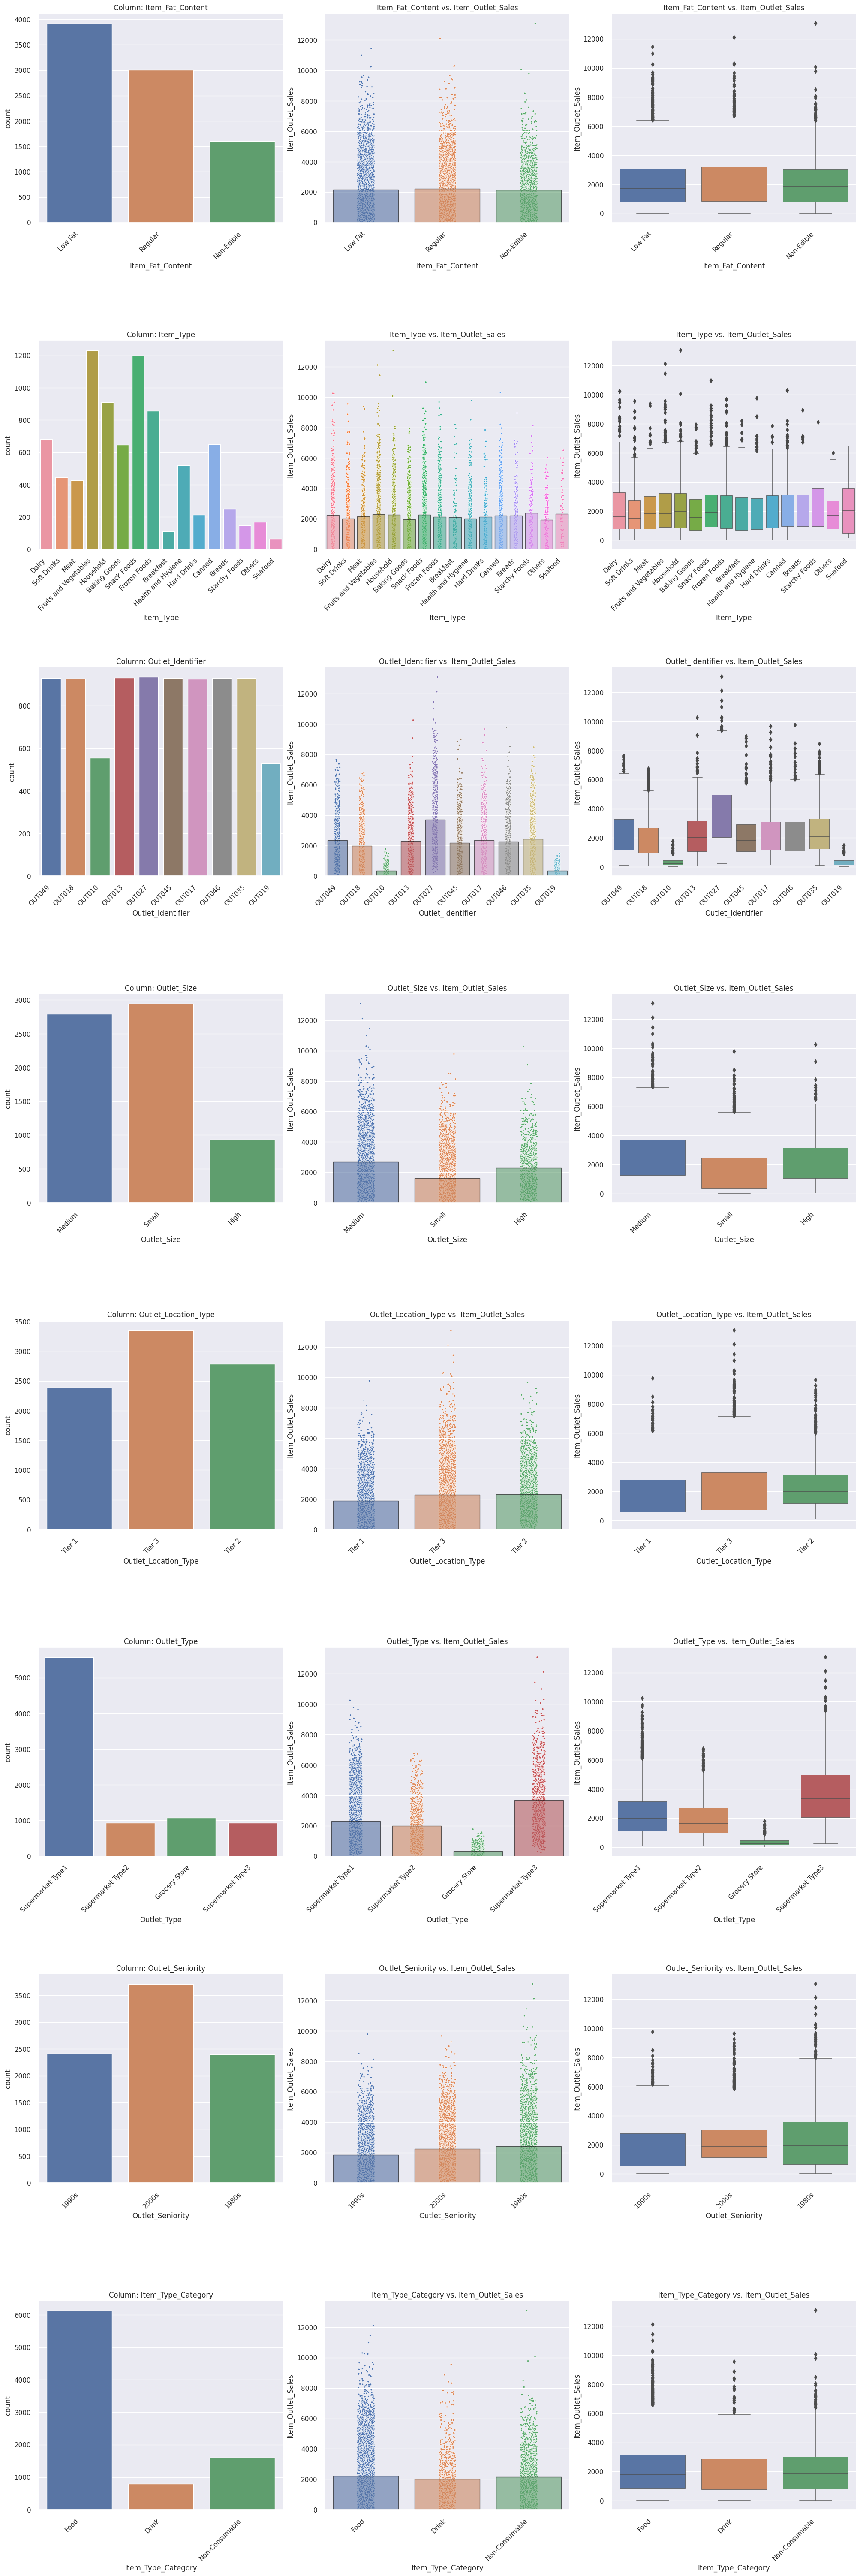

In [121]:

target="Item_Outlet_Sales"
plt.style.use('seaborn')
sns.set(font_scale=1)
order=None

fig, axes = plt.subplots(nrows=len(cat_cols),ncols=3,figsize=(20,7.5*len(cat_cols)))
index=0
scatter_kws={'ec':'white','lw':0.5,'alpha':0.8,'s':10}
axes=axes.flatten()
for col in cat_cols:
  # Plotting a countplot
  sns.countplot(data=df,x=col,ax=axes[index],order=order)
  # Rotate Tick Labels for long names
  axes[index].set_xticklabels(axes[index].get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  axes[index].set_title(f"Column: {col}")

  # Barplot
  sns.barplot(data=df, x=col, y=target, ax=axes[index+1], order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  # Boxplot
  sns.stripplot(data=df, x=col, y=target, hue=col, ax=axes[index+1],
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  #Rotate xlabels
  axes[index+1].set_xticklabels(axes[index+1].get_xticklabels(), rotation=45, ha='right')

  # Add a title
  axes[index+1].set_title(f"{col} vs. {target}")

  # Boxplot
  sns.boxplot(data=df,x=col,y=target,ax=axes[index+2],order=order,linewidth=0.5)
  axes[index+2].set_xticklabels(axes[index+2].get_xticklabels(), rotation=45, ha='right')
  axes[index+2].set_title(f"{col} vs. {target}")

  index +=3
# Fix layout and show plot (before print statements)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)



In [122]:
df["Item_Outlet_Sales_Perc"] = (df["Item_Outlet_Sales"]/np.sum(df["Item_Outlet_Sales"]) *100).round(2)
df["Item_Outlet_Sales_Perc"]
table_Sales_Perc=pd.pivot_table(df,values=["Item_Outlet_Sales_Perc"],columns=["Item_Type_Category"],index=["Outlet_Type","Outlet_Size"],aggfunc={"Item_Outlet_Sales_Perc":[np.sum]},fill_value=0)
table_Sales_Perc

Item_Outlet_Sales_Perc                      
                                                 sum                      
Item_Type_Category                             Drink   Food Non-Consumable
Outlet_Type       Outlet_Size                                             
Grocery Store     Small                         0.03   0.28           0.10
Supermarket Type1 High                          1.01   8.26           2.15
                  Medium                        1.03   8.41           2.26
                  Small                         1.91  17.33           4.35
Supermarket Type2 Medium                        0.88   7.16           1.83
Supermarket Type3 Medium                        1.41  13.93           3.26

In [123]:
def t(x):
  return round((len(x)/len(df)*100),2)
table_Items_Count_Perc=pd.pivot_table(df,values=["Item_Outlet_Sales"],columns=["Item_Type_Category"],index=["Outlet_Type","Outlet_Size"],aggfunc={"Item_Outlet_Sales":[lambda x:t(x)]},fill_value=0)
table_Items_Count_Perc

Item_Outlet_Sales                      
                                       <lambda>                      
Item_Type_Category                        Drink   Food Non-Consumable
Outlet_Type       Outlet_Size                                        
Grocery Store     Small                    1.16   9.05           2.50
Supermarket Type1 High                     1.02   7.80           2.11
                  Medium                   1.09   7.90           1.92
                  Small                    2.05  15.68           4.09
Supermarket Type2 Medium                   0.99   7.87           2.03
Supermarket Type3 Medium                   0.93   8.00           2.04

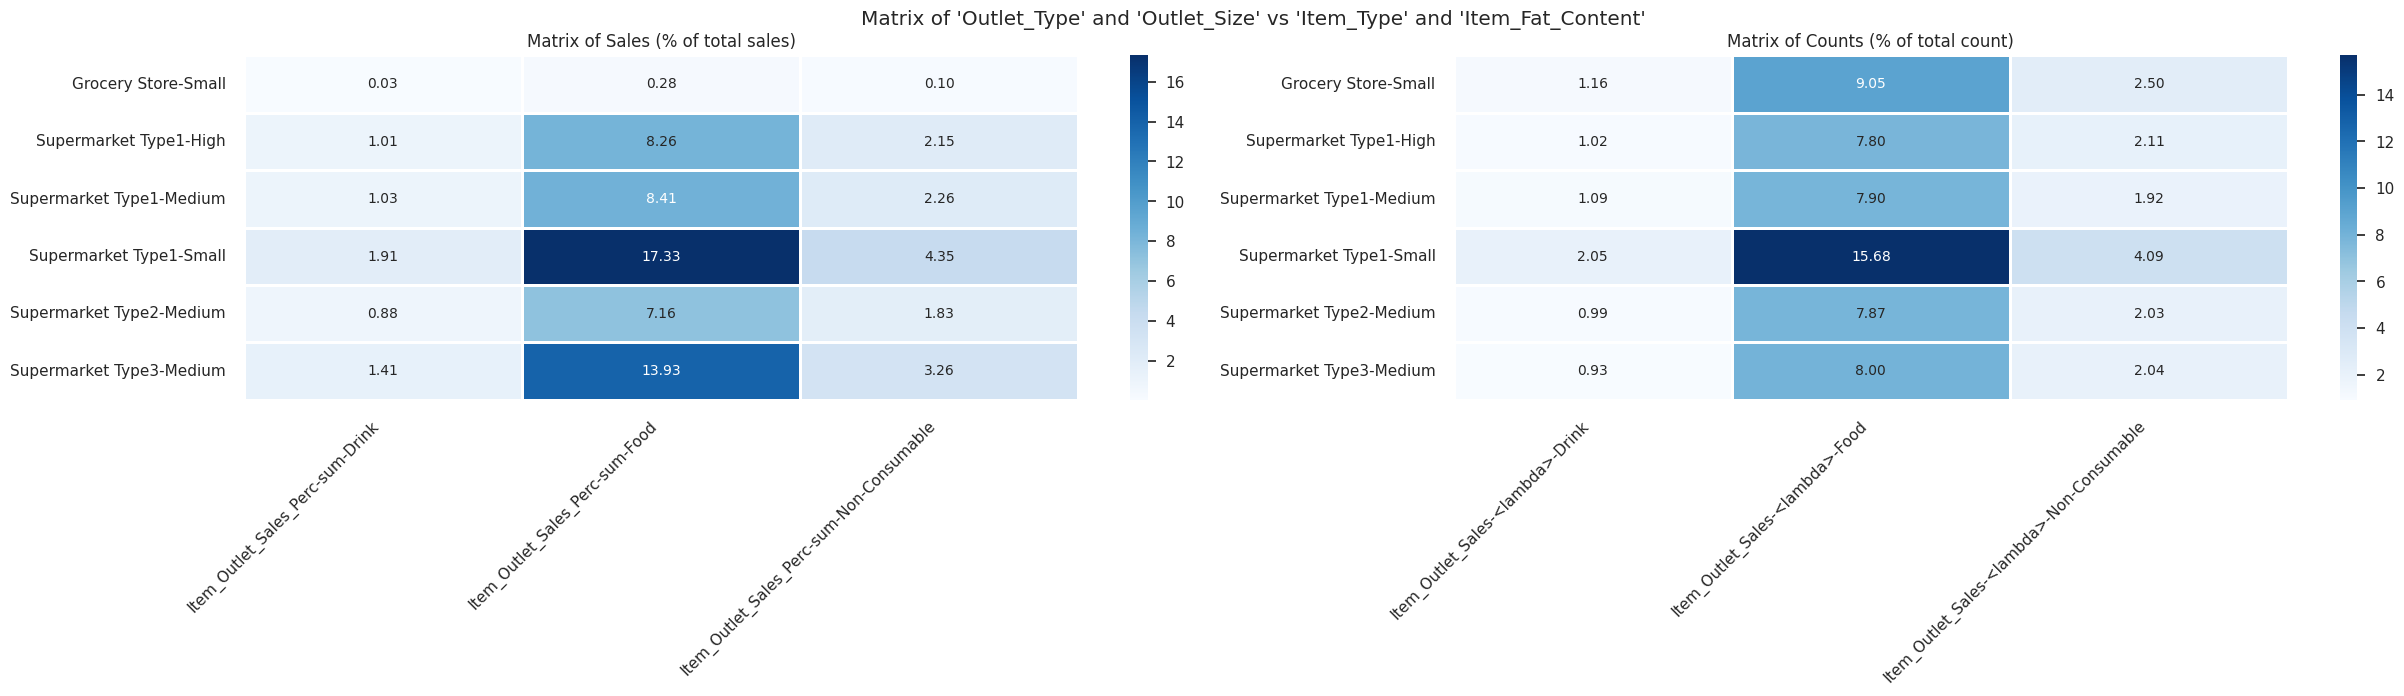

In [124]:
fig, axes=plt.subplots(1,2,figsize=(25,5)) # creating figure and axes
axes=axes.flatten()
fig.suptitle("Matrix of 'Outlet_Type' and 'Outlet_Size' vs 'Item_Type' and 'Item_Fat_Content'") # figure title
sns.heatmap(table_Sales_Perc,cmap='Blues',annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes[0])
axes[0].set_title("Matrix of Sales (% of total sales)")
axes[0].set_ylabel("")
axes[0].set_xlabel("")
sns.heatmap(table_Items_Count_Perc,cmap='Blues',annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f",ax=axes[1])
axes[1].set_title("Matrix of Counts (% of total count)")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
# Fix layout and show plot (before print statements)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
fig.autofmt_xdate(rotation=45) # rotating all axes within the figure

In [125]:
import plotly.express as px
width=1200
height=600
labels={"Item_MRP":"Maximum Retail Price (dollars)","Item_Fat_Content":"Fat Content","Item_Outlet_Sales":"Sales Per Item Per Outlet"}
#df = px.data.gapminder()
fig = px.scatter(df[df["Outlet_Size"]=="Small"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Fat_Content",hover_name="Outlet_Identifier", width=width,height=height,
                 title="Small Sized Outlets",labels=labels)
fig.show()
fig = px.scatter(df[df["Outlet_Size"]=="Medium"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Fat_Content",hover_name="Outlet_Identifier", width=width,height=height,
                 title="Medium Sized Outlets",labels=labels)
fig.show()
fig = px.scatter(df[df["Outlet_Size"]=="High"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Fat_Content",hover_name="Outlet_Identifier", width=width,height=height,
                 title="High Sized Outlets",labels=labels)
fig.show()

In [126]:
import plotly.express as px
width=1200
height=600
labels={"Item_MRP":"Maximum Retail Price (dollars)","Item_Type_Category":"Item Types","Item_Outlet_Sales":"Sales Per Item Per Outlet"}
#df = px.data.gapminder()
for ot in df.Outlet_Type.unique():
  filter=df["Outlet_Type"]==ot
  fig = px.scatter(df[filter], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Type_Category",hover_name="Outlet_Identifier", width=width,height=height,
                 title=ot,labels=labels)
  fig.show()


#fig = px.scatter(df[df["Outlet_Size"]=="Small"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Type_Category",hover_name="Outlet_Identifier", width=width,height=height,title="Small Sized Outlets",labels=labels)
#fig.show()
#fig = px.scatter(df[df["Outlet_Size"]=="Medium"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Type_Category",hover_name="Outlet_Identifier", width=width,height=height,title="Medium Sized Outlets",labels=labels)
#fig.show()
#fig = px.scatter(df[df["Outlet_Size"]=="High"], x="Item_MRP", y="Item_Outlet_Sales",color="Item_Type_Category",hover_name="Outlet_Identifier", width=width,height=height,title="High Sized Outlets",labels=labels)
#fig.show()

In [127]:
df.columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales',
       'Outlet_Seniority', 'Item_Type_Category', 'Item_Outlet_Sales_Perc'],
      dtype='object')

In [129]:
df_model=df.drop(columns=["Outlet_Establishment_Year","Item_Outlet_Sales_Perc"])

In [131]:
# Defining target and Matrix of features
target="Item_Outlet_Sales"
y=df_model[target]
X=df_model.drop(columns=[target])
display(X.head(),y.head())


,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Seniority,Item_Type_Category
0,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,1990s,Food
1,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,2000s,Drink
2,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,1990s,Food
3,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,1990s,Food
4,Non-Edible,NaN,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,1980s,Non-Consumable


0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [132]:
# Splitting dataset into training dataset and testing dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
X_train.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Seniority,Item_Type_Category
4776,Non-Edible,0.029565,Household,256.4646,OUT018,Medium,Tier 3,Supermarket Type2,2000s,Non-Consumable
7510,Regular,NaN,Snack Foods,179.7660,OUT018,Medium,Tier 3,Supermarket Type2,2000s,Food
5828,Regular,0.158716,Meat,157.2946,OUT049,Medium,Tier 1,Supermarket Type1,1990s,Food
5327,Low Fat,0.014628,Baking Goods,82.3250,OUT035,Small,Tier 2,Supermarket Type1,2000s,Food
4810,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,NaN,Tier 2,Supermarket Type1,2000s,Food


In [134]:
# Initiating list of numeric columns
num_cols=X_train.select_dtypes("number").columns
num_cols

# Initiating list of ordinal columns
ord_cols=["Outlet_Size"]
ord_cols


# Initiating list of nominal columns
nom_cols = X_train.select_dtypes("object").drop(columns=ord_cols).columns
nom_cols


# numerical pipeline
num_nan_imputer = SimpleImputer(strategy="constant", fill_value=np.nan)
num_std_scaler = StandardScaler()
num_pipe=make_pipeline(num_nan_imputer,num_std_scaler)

# categorical(nominal) pipeline
nom_cns_imputer = SimpleImputer(strategy="constant", fill_value="MISSING")
nom_ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown="ignore")
nom_pipe=make_pipeline(nom_cns_imputer,nom_ohe_encoder)

# ordinal pipeline
ord_nan_imputer = SimpleImputer(strategy="constant", fill_value="MISSING")
ordered_categories=[["MISSING","Small","Medium","High"]]
ord_encoder = OrdinalEncoder(categories=ordered_categories)
ord_std_scaler = num_std_scaler
ord_pipe=make_pipeline(ord_nan_imputer,ord_encoder,ord_std_scaler)

# Instantiating tupels for column transformer
num_tuple=('numeric',num_pipe,num_cols)
nom_tuple=('nominal',nom_pipe,nom_cols)
ord_tuple=('ordinal',ord_pipe,ord_cols)


# instantiating column transformer
col_transformer=ColumnTransformer([num_tuple,nom_tuple,ord_tuple],verbose_feature_names_out=False,remainder="passthrough")